In [67]:
# loading graph

import igraph as ig
import os, yerbamate, pandas as pd

env = yerbamate.Environment()
graph_save_path = os.path.join(env['save'], 'graph', 'hashtag_communities', 'hashtag_communities_bipart_0finetune.graphml')


path = os.path.join(env["plots"], "analysis", "user_hashtag_before.parquet")

df = pd.read_parquet(path)


df_after = pd.read_parquet(os.path.join(env['plots'], 'analysis', 'user_hashtag_after.parquet'))


hashtags_path = os.path.join(env['save'], 'hashtags', 'top_hashtag_before.csv')

print("Filtering DataFrame...")

# hashtag_counts = df.groupby("hashtag").size().reset_index(name="counts")
top_hashtags = pd.read_csv(hashtags_path)


# replace zero with 1
# top_hashtags["weight"] = top_hashtags["weight"] * 2 + 1

# times 2 if not 1 or 0
top_hashtags["weight"] = top_hashtags["weight"].apply(lambda x: x * 5 + 10 if x >= 1 else x + 1)
# create a set of the top hashtags for faster lookup
top_hashtags_set = set(top_hashtags["hashtag"])

# filter the original DataFrame
df_filtered = df[df["hashtag"].isin(top_hashtags_set)]

df_unfiltered = df[df['userId'].isin(df_filtered['userId'])]

df = df_filtered


# prrint number of unique users and hashtags
print(f"Number of unique users: {len(df['userId'].unique())}")
print(f"Number of unique hashtags: {len(df['hashtag'].unique())}")

print("Loading graph...")

g = ig.Graph.Read_GraphML(graph_save_path)

# map users and hashtags to unique integers
user_mapping = {user: i for i, user in enumerate(df["userId"].unique())}
hashtag_mapping = {
    hashtag: i + len(user_mapping) for i, hashtag in enumerate(df["hashtag"].unique())
}

  

df["user_id"] = df["userId"].map(user_mapping)
df["hashtag_id"] = df["hashtag"].map(hashtag_mapping)

df['community'] = df['user_id'].map( lambda x: g.vs[x]['partition'])


# df after has differet size, we only want to keep people that are in the graph
df_after = df_after[df_after['userId'].isin(df['userId'].unique())]

df_after["user_id"] = df_after["userId"].map(user_mapping)
# df_after["hashtag_id"] = df_after["hashtag"].map(hashtag_mapping)

df_after['community'] = df_after['user_id'].map( lambda x: g.vs[x]['partition'])
df_unfiltered['user_id'] = df_unfiltered['userId'].map(user_mapping)
df_unfiltered['community'] = df_unfiltered['user_id'].map( lambda x: g.vs[x]['partition'])
df_unfiltered['hashtag_id'] = df_unfiltered['hashtag'].map(hashtag_mapping)


Filtering DataFrame...
Number of unique users: 109227
Number of unique hashtags: 1503
Loading graph...


In [5]:
# loading graph

import igraph as ig
import os, yerbamate, pandas as pd

env = yerbamate.Environment()
graph_save_path = os.path.join(env['save'], 'graph', 'hashtag_communities', 'hashtag_communities_bipart.graphml')


df = pd.read_parquet(os.path.join(env['plots'], 'analysis', 'user_hashtag_before.parquet'))
df_after = pd.read_parquet(os.path.join(env['plots'], 'analysis', 'user_hashtag_after.parquet'))

hashtag_counts = df.groupby("hashtag").size().reset_index(name="counts")

top_hashtags = hashtag_counts.sort_values("counts", ascending=False).iloc[:1500]
# create a set of the top hashtags for faster lookup
top_hashtags_set = set(top_hashtags["hashtag"])

# filter the original DataFrame
df_filtered = df[df["hashtag"].isin(top_hashtags_set)]

df = df_filtered

# filter all with users in df
df_after = df_after[df_after['userId'].isin(df['userId'].unique())]

# prrint number of unique users and hashtags
print(f"Number of unique users: {len(df['userId'].unique())}")
print(f"Number of unique hashtags: {len(df['hashtag'].unique())}")

print("Loading graph...")

g = ig.Graph.Read_GraphML(graph_save_path)

# map users and hashtags to unique integers
user_mapping = {user: i for i, user in enumerate(df["userId"].unique())}
hashtag_mapping = {
    hashtag: i + len(user_mapping) for i, hashtag in enumerate(df["hashtag"].unique())
}

print("Computing edges...")
 

df["user_id"] = df["userId"].map(user_mapping)
df["hashtag_id"] = df["hashtag"].map(hashtag_mapping)

df['community'] = df['user_id'].map( lambda x: g.vs[x]['partition'])

df_after["user_id"] = df_after["userId"].map(user_mapping)
# df_all["hashtag_id"] = df_all["hashtag"].map(hashtag_mapping)
df_after['community'] = df_after['user_id'].map( lambda x: g.vs[x]['partition'])

Number of unique users: 114838
Number of unique hashtags: 1500
Loading graph...
Computing edges...


In [30]:
df.head()

userId         hashtag  count  user_id  hashtag_id  community
0     72516079  QueenElizabeth     16        0      114838        4.0
32    72516079          Israel     11        0      114839        4.0
86    72516079           Trump     13        0      114840        4.0
115   72516079     Afghanistan      5        0      114841        4.0
199  169108336          المغرب    110        1      114842        4.0

In [31]:
# group the data by community and hashtag and sum the total usage for each combination
community_hashtag_counts = df.groupby(['community', 'hashtag'])['count'].sum().reset_index(name='total_count')

# calculate the total number of hashtag uses in each community
community_counts = df.groupby('community')['count'].sum()

# calculate the total number of uses for each hashtag
hashtag_counts = df.groupby('hashtag')['count'].sum()

# calculate the proportion of hashtag usage in each community
community_hashtag_counts['proportion_in_community'] = community_hashtag_counts.apply(lambda row: row['total_count'] / community_counts[row['community']], axis=1)

# calculate the proportion of hashtag usage in other communities
# community_hashtag_counts['proportion_in_other_communities'] = community_hashtag_counts.apply(lambda row: (hashtag_counts[row['hashtag']] - row['total_count']) / (hashtag_counts.sum() - community_counts[row['community']]), axis=1)
# community_hashtag_counts['proportion_in_other_communities'] = community_hashtag_counts.apply(lambda row: (hashtag_counts[row['hashtag']] - row['total_count']) / hashtag_counts[row['hashtag']], axis=1)
community_hashtag_counts['proportion_in_other_communities'] = community_hashtag_counts.apply(lambda row: (hashtag_counts[row['hashtag']] - row['total_count']) / hashtag_counts[row['hashtag']], axis=1)


# select the top hashtags in each community
top_hashtags = community_hashtag_counts.groupby('community').apply(lambda group: group.nlargest(2000, 'total_count'))

# select the hashtags that have a high proportion of usage in the community and a low proportion of usage in other communities
# exclusive_hashtags = top_hashtags[(top_hashtags['proportion_in_community'] > 0.05) & (top_hashtags['proportion_in_other_communities'] < 0.001)]


In [53]:
exclusive_hashtags = top_hashtags[(top_hashtags['proportion_in_community'] > 0.001) & (top_hashtags['proportion_in_other_communities'] < 0.5)]

exclusive_hashtags[exclusive_hashtags['community'] == 2].head(100)['hashtag'].values

array(['ایران', 'FreeIran2022', 'قیام_تا_سرنگونی', 'اوکراین',
       'نه_شاه_نه_شیخ', 'روسیه', 'NoVisa4Raisi', 'برجام', 'مجاهدین_خلق',
       'میتوان_و_باید', 'رئیسی_جلاد۶۷', 'DontFreeTerrorists', 'تهران',
       'کانونهای_شورشی', 'No2Appeasement', 'رئیسی', 'مسعود_رجوی',
       'قيام_تا_سرنگونی', 'مریم_رجوی', 'آمریکا', 'WeCanAndMust',
       'قتل_عام۶۷', 'پوتین', 'خامنه\u200cای', 'دیپلمات_تروریست',
       'سرنگونی', 'آری_به_جمهوری_دمکراتیک', 'استقلال', 'حمید_نوری',
       'قيام_تا_سرنگونى', 'دادخواهی', 'FreeIranTelethon',
       'ProsecuteRaisiNow', 'بورس', 'حقوق_بشر', 'همیاری', 'کرونا', 'فوری',
       'ProsecuteRaisiNOW', 'WeStand4FreeIran', 'اسرائیل',
       'جمهوری_اسلامی', 'خامنه\u200cای_جنایتکار', 'براندازم', 'افغانستان',
       'مريم_رجوی', 'بازنشستگان', 'ترکیه', 'اعتراضات_سراسری_معلمان',
       'قالیباف', 'مشهد', 'مردم', 'زنان', 'سپاه', 'تورم', 'گشت_ارشاد',
       'اصفهان', 'چین', 'انحلال_سپاه_پاسداران', 'نوروز', 'دلار',
       'نه_به_اعدام', 'عراق', 'مذاکرات_وین', 'حجاب', 'پرسپ

In [76]:
import os

# Group the data by 'community' and apply custom logic to select the top 100 hashtags for each group
grouped_hashtags = top_hashtags.groupby('community').apply(lambda x: x.nlargest(1000, 'total_count'))

# Reset the index of the grouped DataFrame
grouped_hashtags = grouped_hashtags.reset_index(drop=True)

# Save the grouped hashtags as JSON
save_path = os.path.join(env['save'], 'hashtags', 'top_hashtags_before.json')
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))
grouped_hashtags[['community', 'hashtag']].to_json(save_path, orient='records', force_ascii=False)


ValueError: 'community' is both an index level and a column label, which is ambiguous.

In [79]:
import os

# Calculate the total count for each hashtag across all communities
hashtag_counts = df.groupby('hashtag')['count'].sum().reset_index()

# Merge the total count back into the original DataFrame
df_merged = df.merge(hashtag_counts, on='hashtag', suffixes=('', '_total'))

# Calculate the portion of users and count for each hashtag within each community
df_merged['portion_in_community'] = df_merged['count'] / df_merged['count_total']
df_merged['portion_in_community'] = df_merged['portion_in_community'].fillna(0)
df_merged['count'] = df_merged['count'].fillna(0)

# Group the data by 'community' and select the top 200 hashtags for each group
grouped_hashtags = df_merged.groupby(['community', 'hashtag']).agg({'count': 'sum', 'portion_in_community': 'sum'}).reset_index()

# Sort the hashtags within each community by the summed counts in descending order
grouped_hashtags = grouped_hashtags.groupby('community').apply(lambda x: x.nlargest(200, 'count')).reset_index(drop=True)

# Save the grouped hashtags as JSON
save_path = os.path.join(env['save'], 'hashtags', 'top_hashtags_before.json')
os.makedirs(os.path.dirname(save_path), exist_ok=True)
grouped_hashtags[['community', 'hashtag', 'count', 'portion_in_community']].to_json(save_path, orient='records', force_ascii=False)


In [59]:

import json
import os

# Load translation cache
with open(os.path.join(env['save'],'translation_cache.json'), 'r') as f:
    translation_cache = json.load(f)

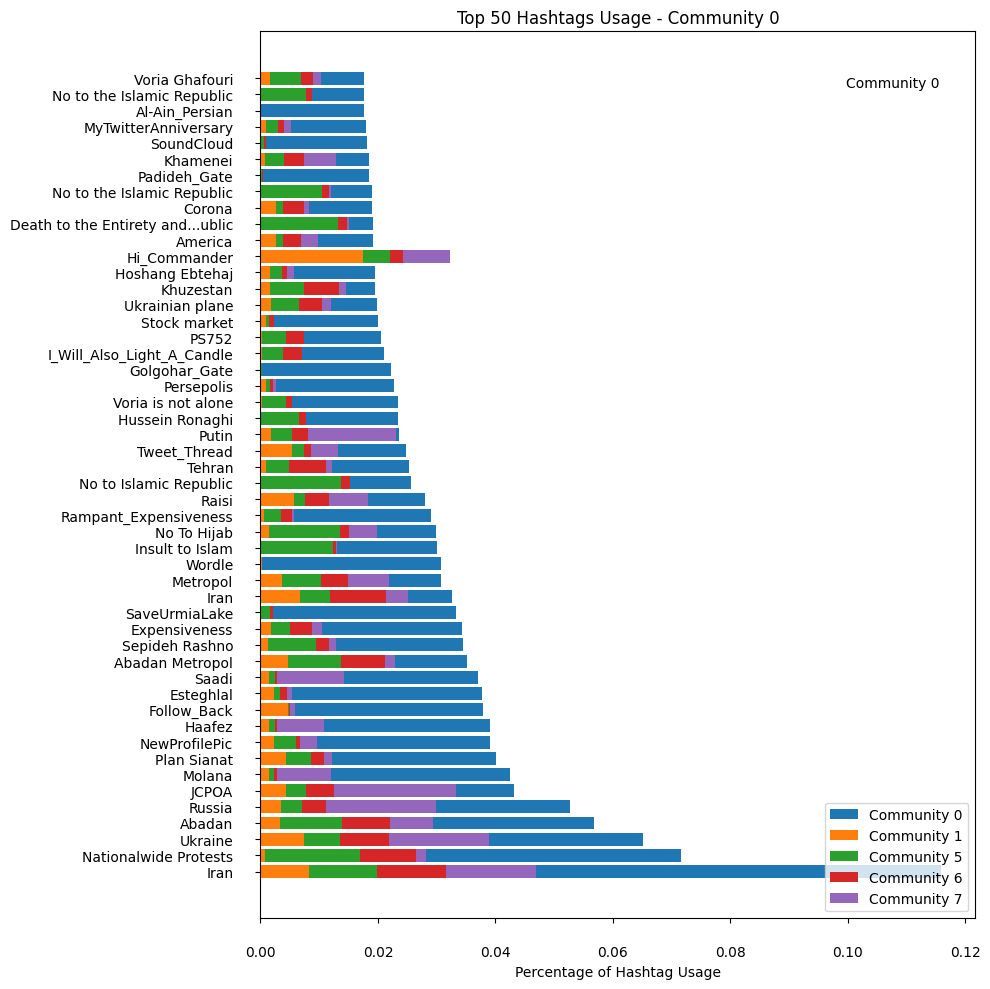

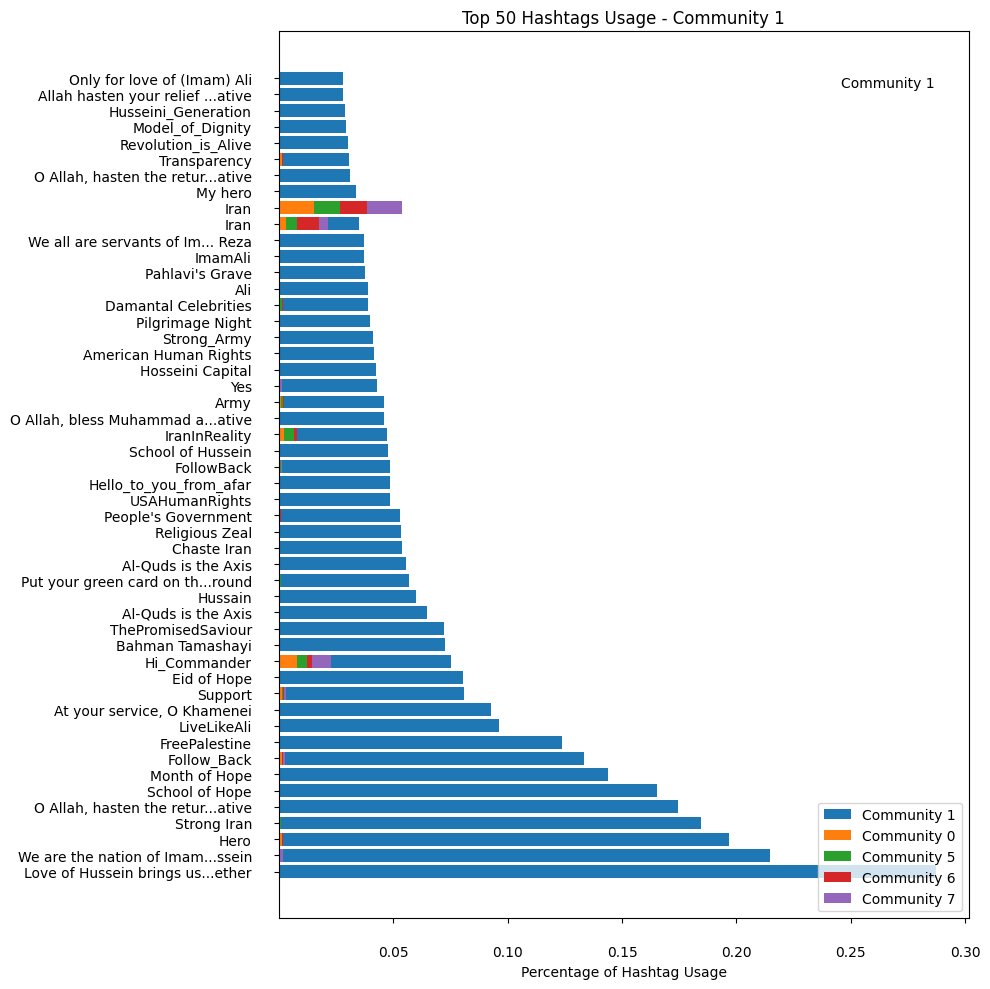

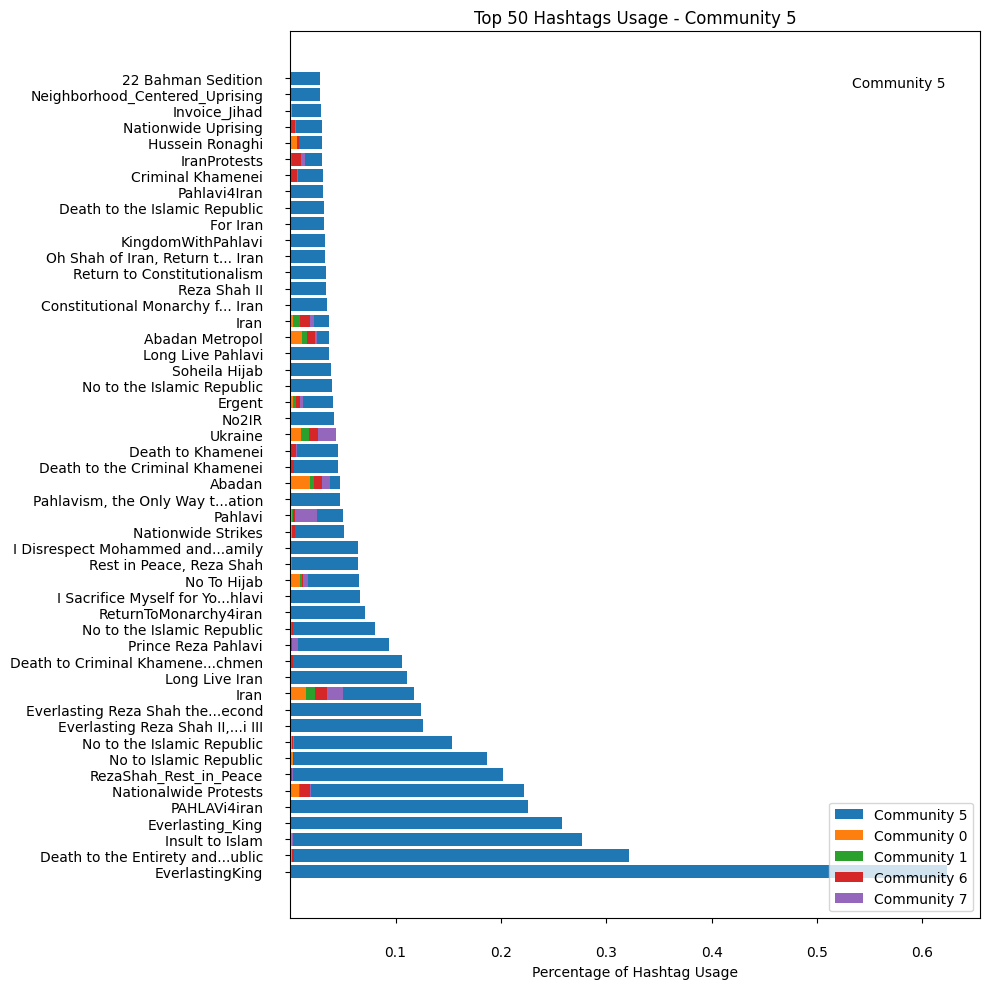

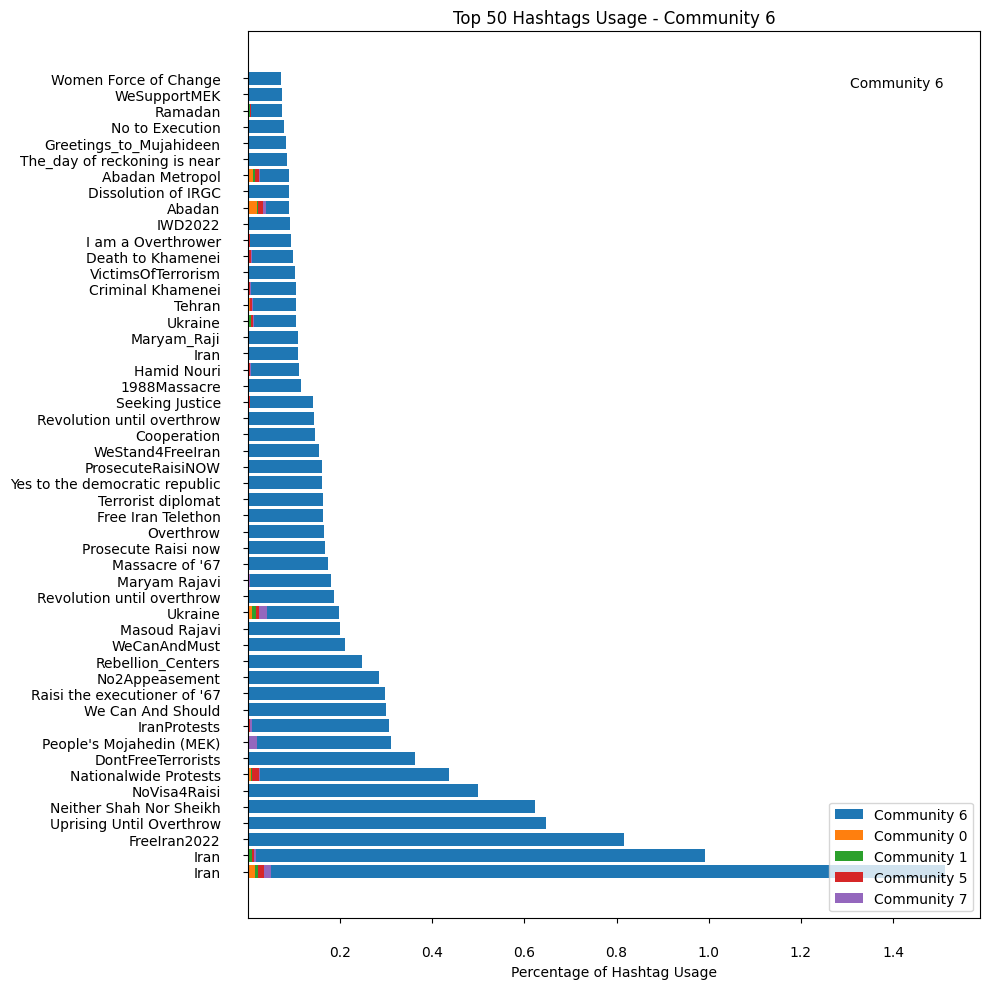

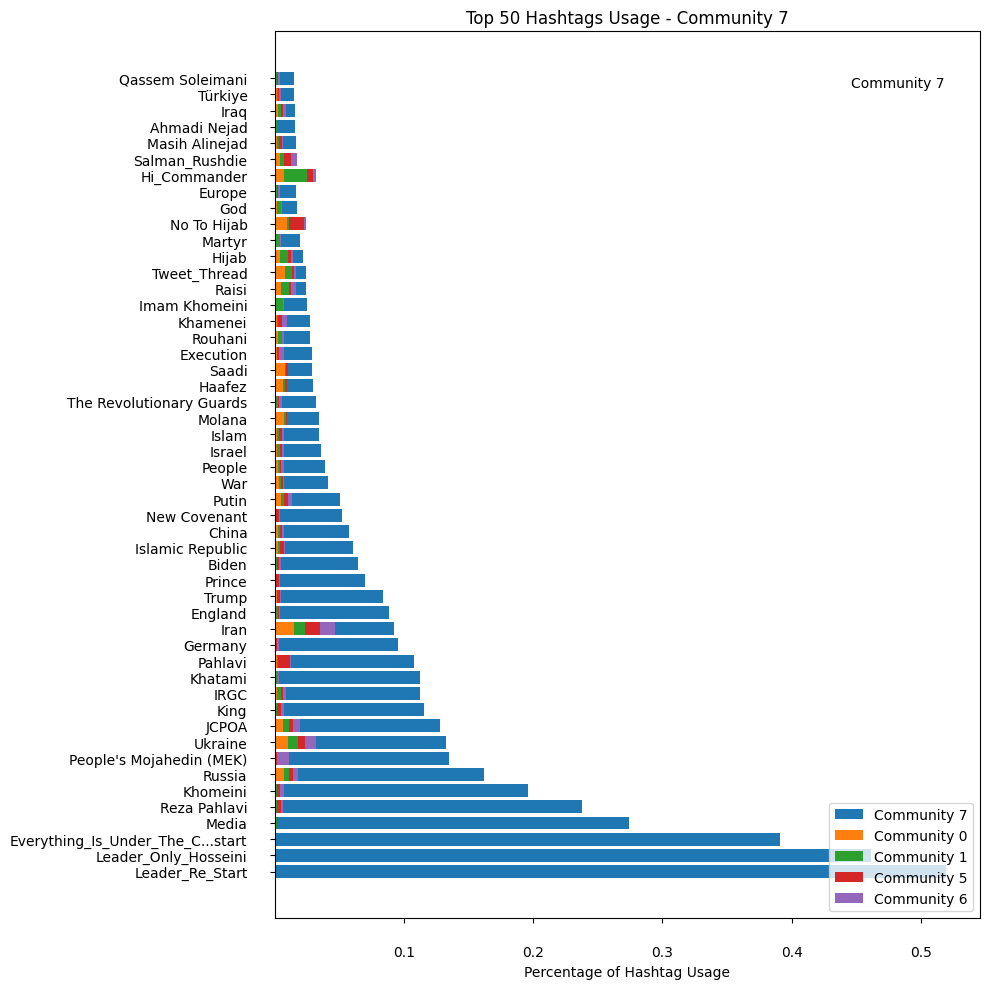

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of top hashtags to show for each community
top_n = 50

# Define the communities to include
communities = [0, 1, 5, 6, 7]

# Iterate over each community
for i, community in enumerate(communities):
    # Filter the data for the current community
    community_data = df[df['community'] == community]
    
    # Group the data by hashtag and calculate the number of unique users for each hashtag
    hashtag_counts = community_data.groupby('hashtag')['user_id'].nunique()
    
    # Get the top N hashtags for the current community
    top_hashtags = community_data.groupby('hashtag')['count'].sum().nlargest(top_n)
    
    # Get the unique hashtags and their indices
    hashtags = top_hashtags.index.tolist()
    indices = np.arange(len(hashtags))
    
    # Initialize arrays for storing the proportions of users for each hashtag in the current community and other communities
    proportion_data_current = np.zeros(len(hashtags))
    proportion_data_other = np.zeros((len(hashtags), len(communities) - 1))
    
    # Calculate the proportions of unique users for each hashtag in the current community
    for j, hashtag in enumerate(hashtags):
        proportion_current = top_hashtags[hashtag] / hashtag_counts.sum()
        proportion_data_current[j] = proportion_current
    
    # Calculate the proportions of unique users for each hashtag in the other communities
    other_communities = [c for c in communities if c != community]
    for j, other_community in enumerate(other_communities):
        other_community_data = df[df['community'] == other_community]
        other_hashtag_counts = other_community_data.groupby('hashtag')['user_id'].nunique()
        
        for k, hashtag in enumerate(hashtags):
            if hashtag in other_hashtag_counts:
                proportion_other = other_hashtag_counts[hashtag] / other_hashtag_counts.sum()
            else:
                proportion_other = 0
            proportion_data_other[k, j] = proportion_other

    
    # Create the stacked bar chart for the current community
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.barh(indices, proportion_data_current, label=f'Community {community}')
    bottom = np.zeros(len(hashtags))
    for j, other_community in enumerate(other_communities):
        ax.barh(indices, proportion_data_other[:, j], left=bottom, label=f'Community {other_community}')
        bottom += proportion_data_other[:, j]
    # map hashtags to translated versions
    hashtags = [translation_cache.get(hashtag, hashtag) for hashtag in hashtags]

    # trim hashtags to max 50 characters, remove middle and add ellipsis
    hashtags = [hashtag[:25] + '...' + hashtag[-5:] if len(hashtag) > 30 else hashtag for hashtag in hashtags]

    # Set the y-axis tick labels and rotation for better readability
    ax.set_yticks(indices)
    ax.set_yticklabels(hashtags)
    
    # Set the x-axis label
    ax.set_xlabel('Percentage of Hashtag Usage')
    
    # Set the title for the current community
    ax.set_title(f'Top {top_n} Hashtags Usage - Community {int(community)}')
    ax.tick_params(axis='y', which='major', pad=16)
    ax.tick_params(axis='x', which='major', pad=16)
    # Set the legend
    ax.legend(loc='lower right')
    fig.tight_layout()
    
    # Add the label for the community in the top right corner of the plot
    ax.text(0.95, 0.95, f'Community {community}', transform=ax.transAxes, ha='right', va='top', fontsize=10)

    # Display the chart
    plt.show()


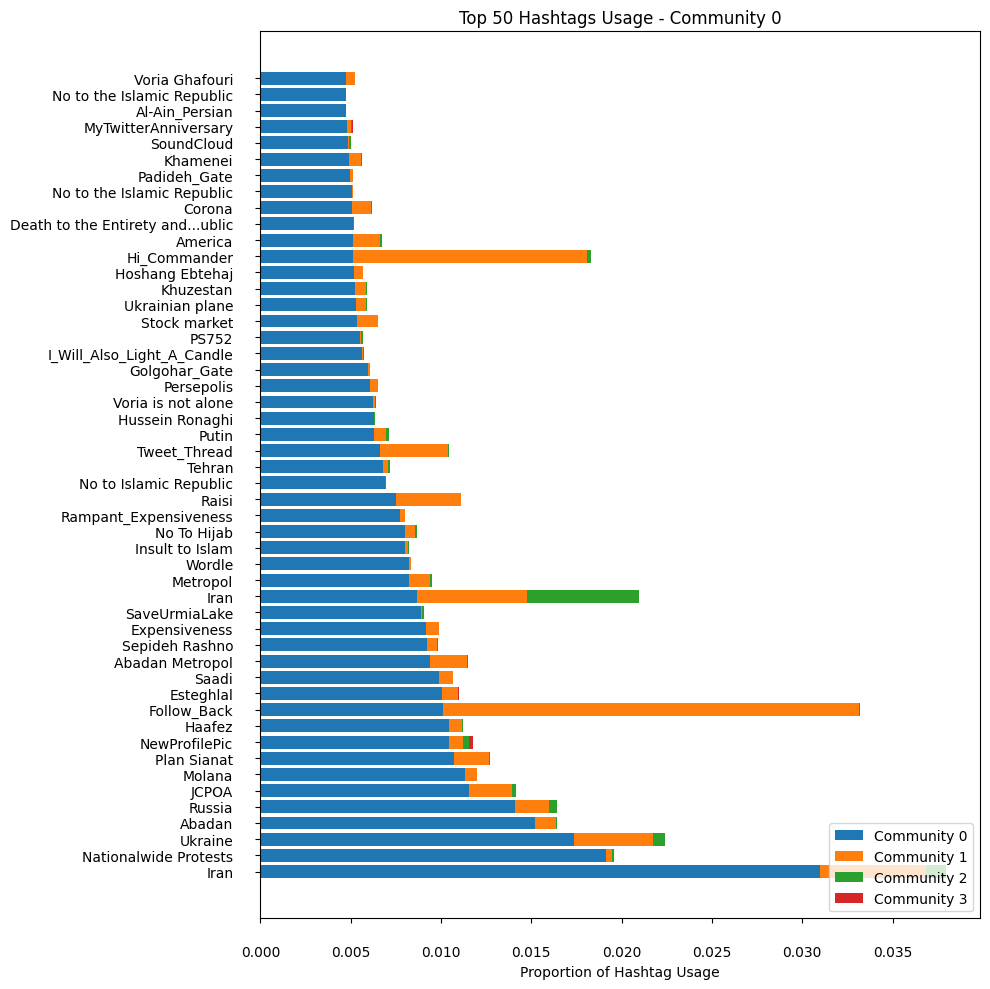

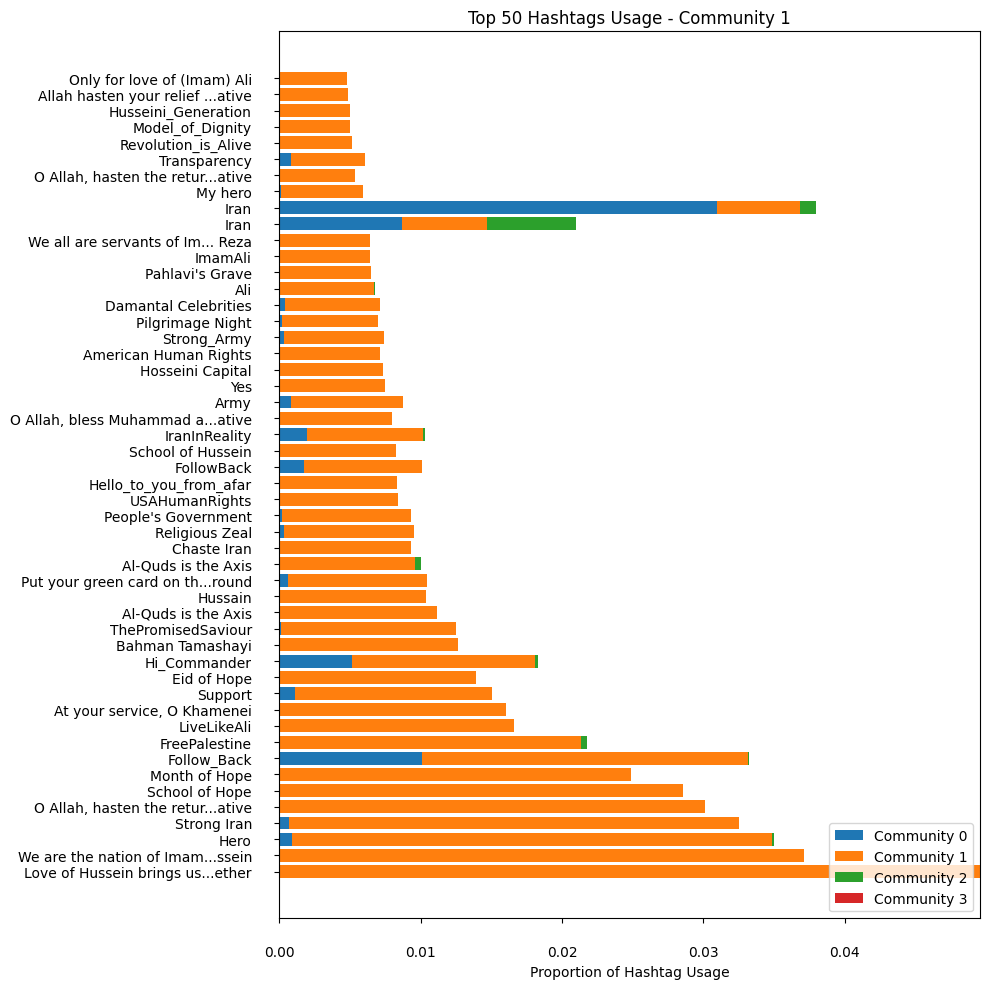

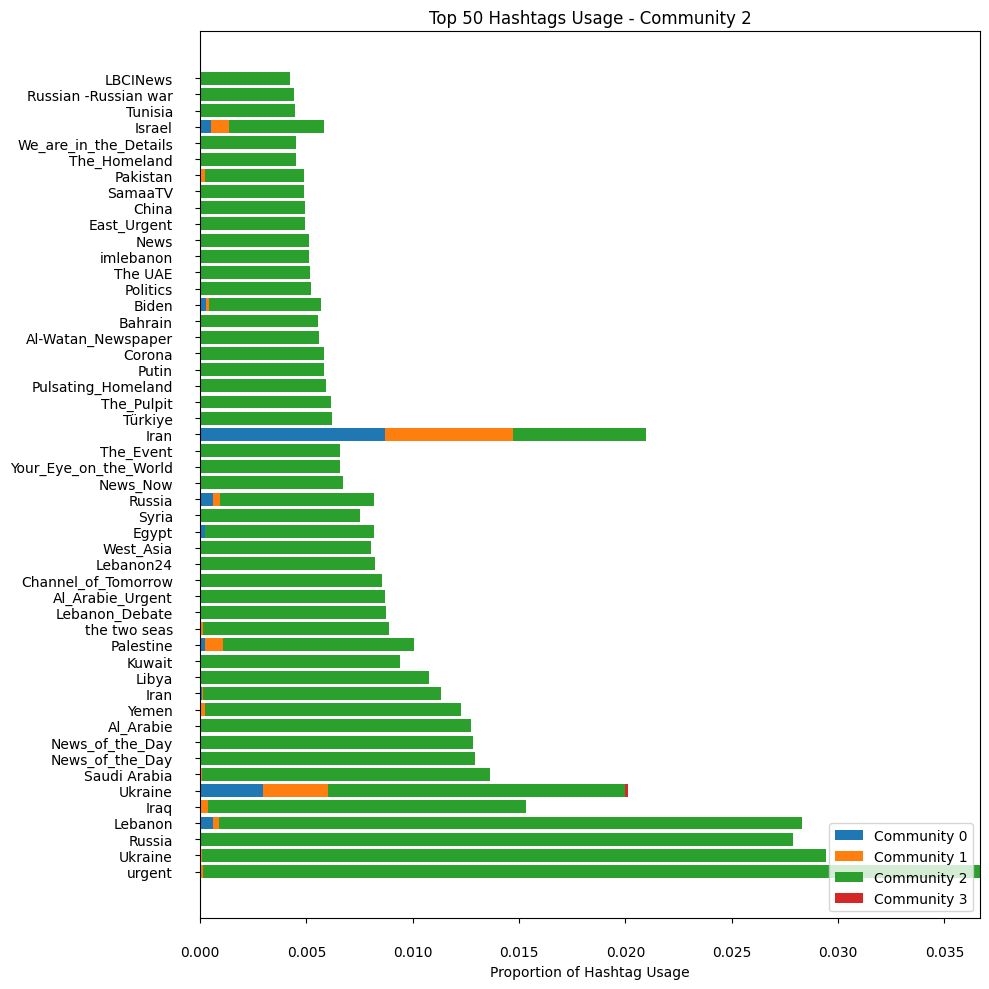

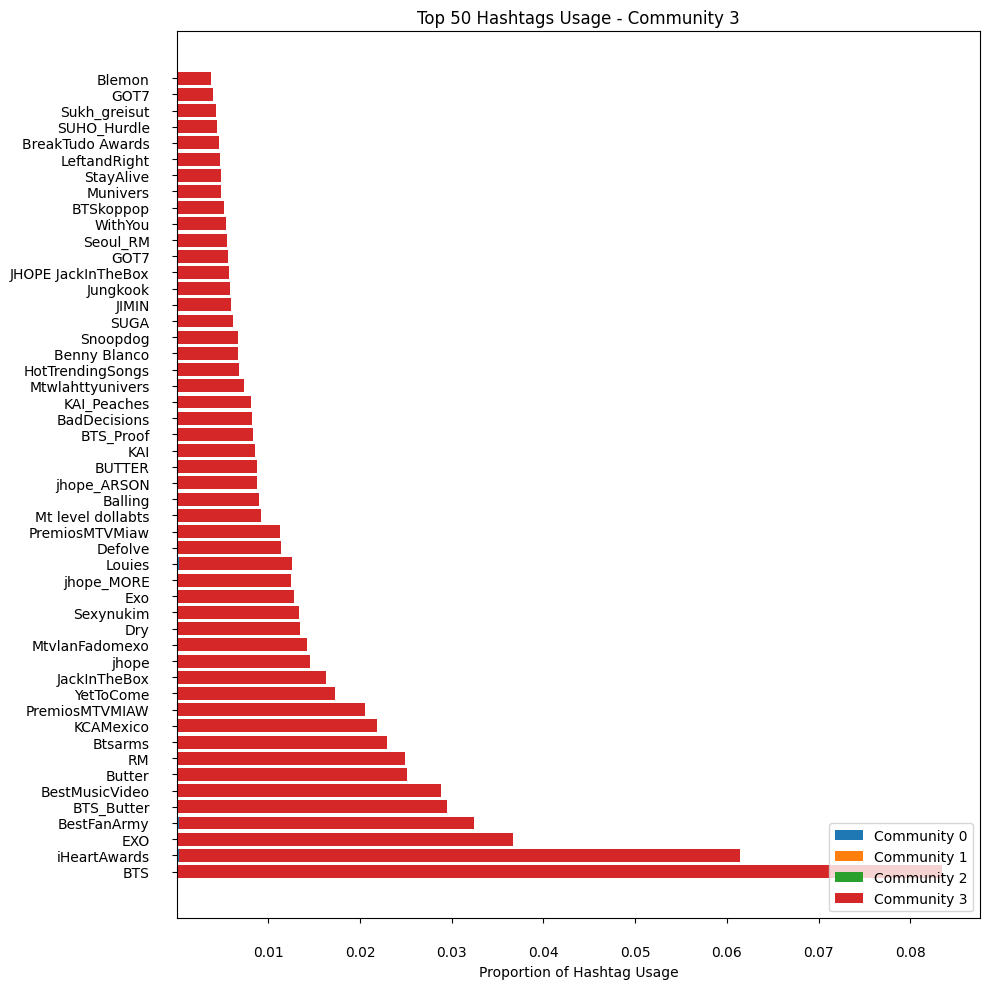

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of top hashtags to show for each community
top_n = 50

# Define the communities to include
communities = [0, 1, 2, 3]

# Iterate over each community
for i, community in enumerate(communities):
    # Filter the data for the current community
    community_data = df[df["community"] == community]

    # Group the data by hashtag and calculate the total count for each hashtag
    hashtag_counts = community_data.groupby("hashtag")["count"].sum()

    # Get the top N hashtags for the current community
    top_hashtags = hashtag_counts.nlargest(top_n)

    # Get the unique hashtags and their indices
    hashtags = top_hashtags.index.tolist()
    indices = np.arange(len(hashtags))

    # Initialize arrays for storing the proportions of hashtag usage in all communities
    proportion_data_all = np.zeros((len(hashtags), len(communities)))

    # Calculate the proportions of unique users for each hashtag in all communities
    for j, other_community in enumerate(communities):
        other_community_data = df[df["community"] == other_community]
        other_hashtag_counts = other_community_data.groupby("hashtag")["count"].sum()

        for k, hashtag in enumerate(hashtags):
            proportion_other = (
                other_hashtag_counts.get(hashtag, 0) / other_hashtag_counts.sum()
            )
            proportion_data_all[k, j] = proportion_other

    # Create the stacked bar chart for the current community
    fig, ax = plt.subplots(figsize=(10, 10))
    bottom = np.zeros(len(hashtags))
    for j, other_community in enumerate(communities):
        ax.barh(
            indices,
            proportion_data_all[:, j],
            left=bottom,
            label=f"Community {other_community}",
        )
        bottom += proportion_data_all[:, j]

    # Map hashtags to translated versions
    hashtags = [translation_cache.get(hashtag, hashtag) for hashtag in hashtags]

    # Trim hashtags to max 50 characters, remove middle and add ellipsis
    hashtags = [
        hashtag[:25] + "..." + hashtag[-5:] if len(hashtag) > 30 else hashtag
        for hashtag in hashtags
    ]

    # Set the y-axis tick labels and rotation for better readability
    ax.set_yticks(indices)
    ax.set_yticklabels(hashtags)

    # Set the x-axis label
    ax.set_xlabel("Proportion of Hashtag Usage")

    # Set the title for the current community
    ax.set_title(f"Top {top_n} Hashtags Usage - Community {community}")

    ax.tick_params(axis="y", which="major", pad=16)
    ax.tick_params(axis="x", which="major", pad=16)
    # Set the legend
    ax.legend(loc="lower right")
    fig.tight_layout()

    save_path = os.path.join(
        env["plots"],
        "analysis",
        "hashtag",
        "top_per_community",
        "graph_0_{i}.png".format(i=i),
    )

    # if dir not exists, create it
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))

    plt.savefig(save_path, dpi=300)

    # Display the chart
    #plt.show()

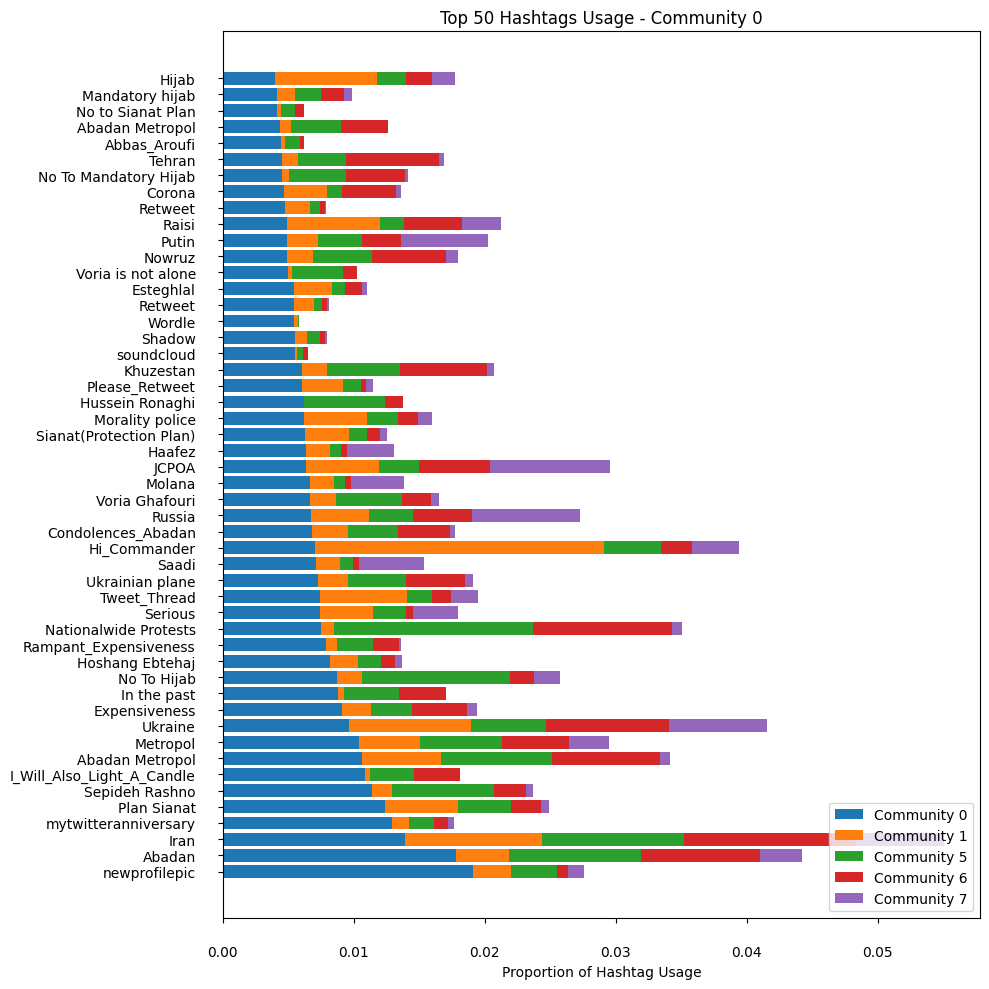

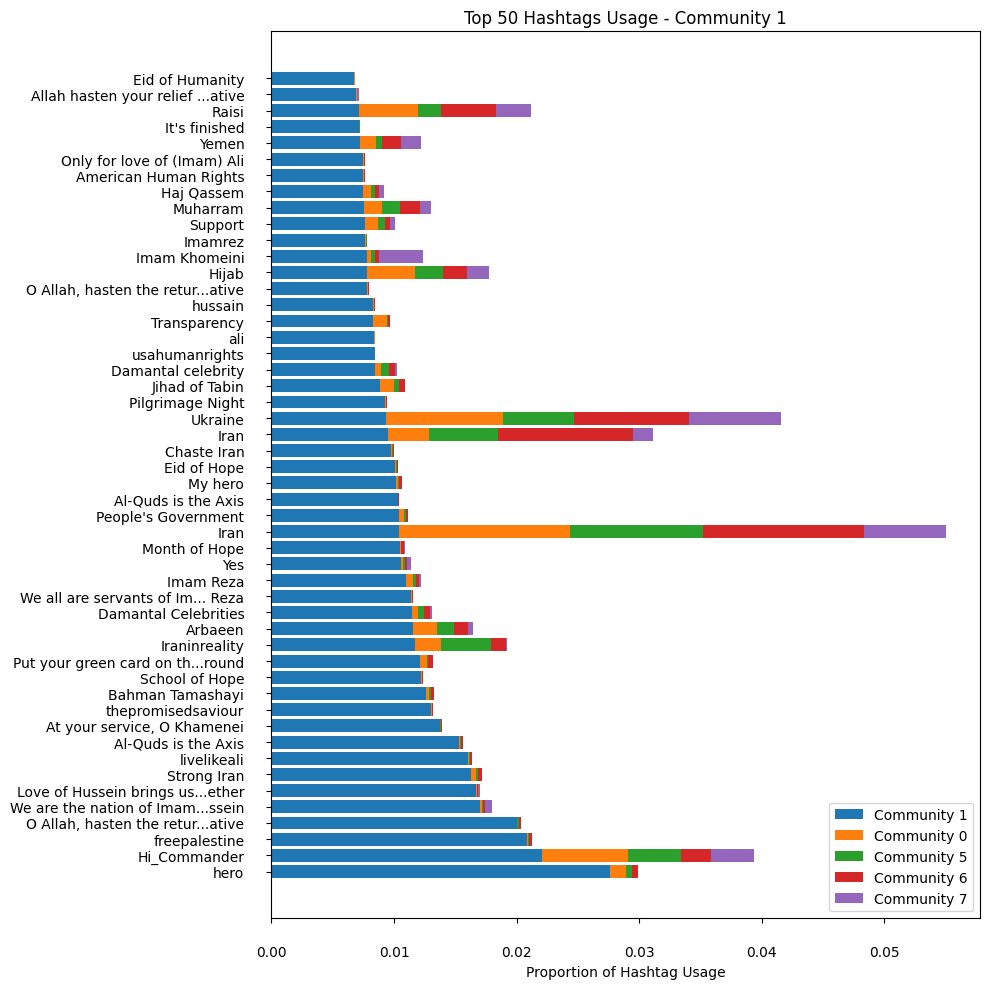

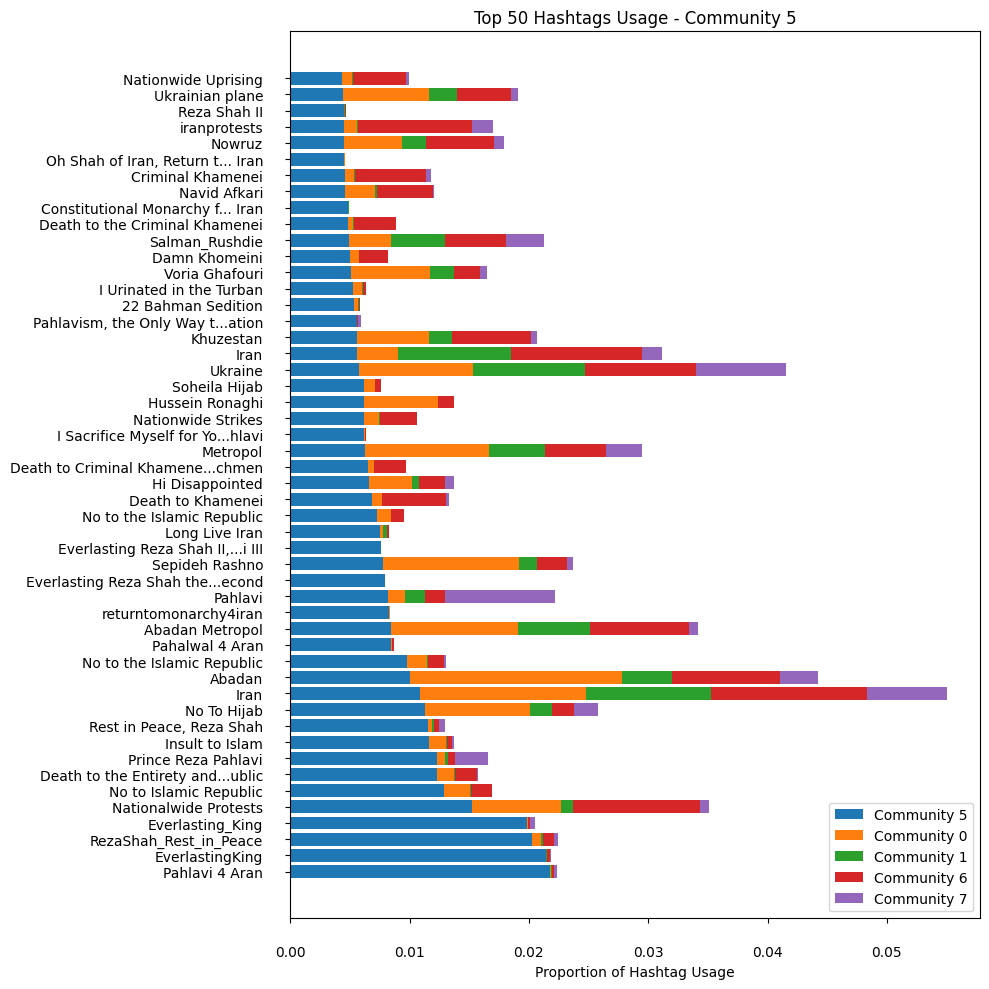

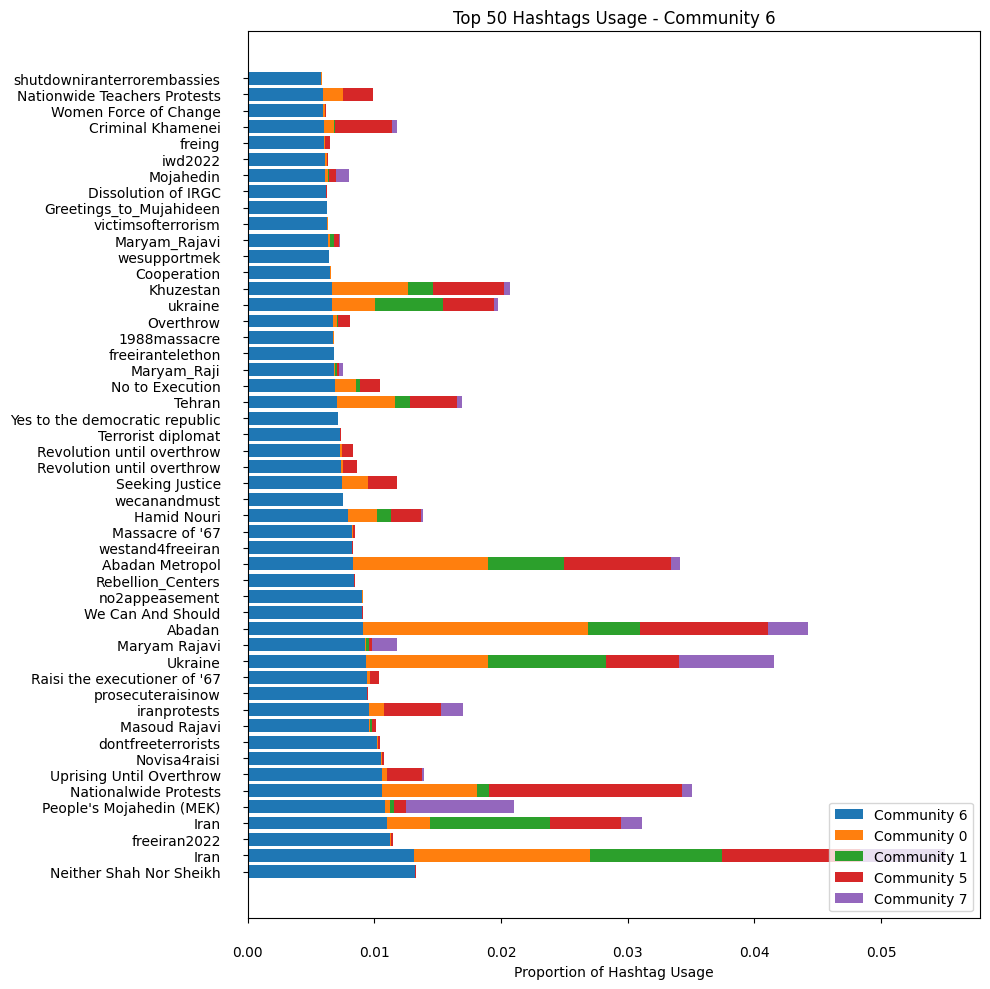

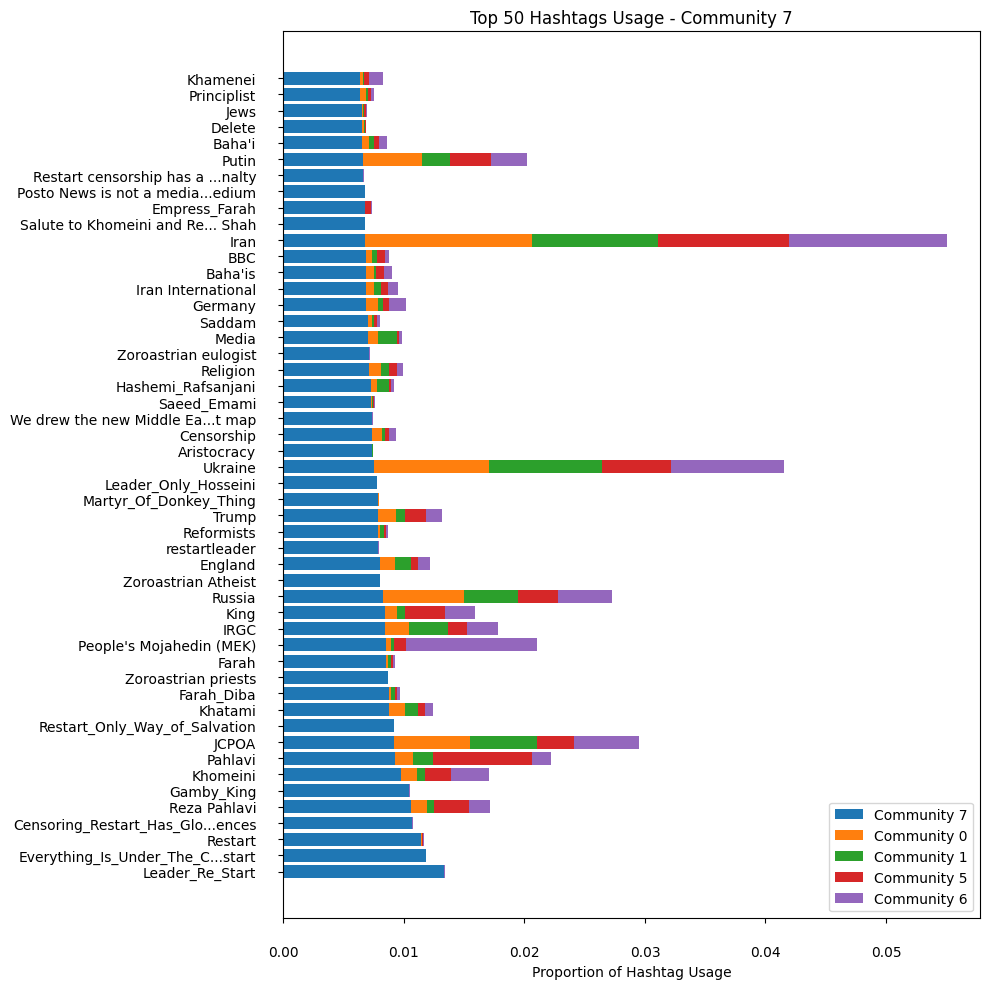

In [64]:

from googletrans import Translator
from httpx import Timeout
import time

translator = Translator(service_urls=['translate.google.com'], timeout=Timeout(5))

def translate(hashtag):
    """Translate a hashtag to English using the Google Translate API.

    Args:
        hashtag (str): The hashtag to translate.

    Returns:
        str: The translated hashtag.
    """
    # Translate the hashtag to English

    translated_hashtag = None
    while translated_hashtag is None:
        try:
            translation = translator.translate(hashtag.replace("_", " "), dest='en', src='auto')
            if hasattr(translation, 'text') and translation.text is not None:
                translated_hashtag = translation.text
                translation_cache[hashtag] = translated_hashtag
        except:
            time.sleep(5)  # Wait for 5 seconds before retrying
            continue
    # Return the translated hashtag
    return translation.text

import matplotlib.pyplot as plt
import numpy as np

# Define the number of top hashtags to show for each community
top_n = 50

# Define the communities to include
communities = [0, 1, 5, 6,7]
# Define a color map for communities


# Iterate over each community
for i, community in enumerate(communities):
    # Filter the data for the current community
    community_data = df_unfiltered[df_unfiltered["community"] == community]

    # Group the data by hashtag and calculate the total count for each hashtag
    hashtag_counts = community_data.groupby("hashtag")["user_id"].nunique()

    # Get the top N hashtags for the current community
    top_hashtags = hashtag_counts.nlargest(top_n)

    # Get the unique hashtags and their indices
    hashtags = top_hashtags.index.tolist()
    indices = np.arange(len(hashtags))

    # Initialize arrays for storing the proportions of hashtag usage in all communities
    proportion_data_all = np.zeros((len(hashtags), len(communities)))

    # Calculate the proportions of unique users for each hashtag in all communities
    for j, other_community in enumerate([community] + [c for c in communities if c != community]):
        other_community_data = df_unfiltered[df_unfiltered["community"] == other_community]
        other_hashtag_counts = other_community_data.groupby("hashtag")["user_id"].nunique()

        for k, hashtag in enumerate(hashtags):
            proportion_other = (
                other_hashtag_counts.get(hashtag, 0) / other_hashtag_counts.count()
            )
            proportion_data_all[k, j] = proportion_other

    # Create the stacked bar chart for the current community
    fig, ax = plt.subplots(figsize=(10, 10))
    bottom = np.zeros(len(hashtags))
    

    for j, other_community in enumerate([community] + [c for c in communities if c != community]):
        ax.barh(
            indices,
            proportion_data_all[:, j],
            left=bottom,
            label=f"Community {other_community}"
        )
        bottom += proportion_data_all[:, j]
        

    # Map hashtags to translated versions
    hashtags = [translation_cache.get(hashtag, hashtag) for hashtag in hashtags]




    # Trim hashtags to max 50 characters, remove middle and add ellipsis
    hashtags = [
        hashtag[:25] + "..." + hashtag[-5:] if len(hashtag) > 30 else hashtag
        for hashtag in hashtags
    ]

    # Set the y-axis tick labels and rotation for better readability
    ax.set_yticks(indices)
    ax.set_yticklabels(hashtags)

    # Set the x-axis label
    ax.set_xlabel("Proportion of Hashtag Usage")

    # Set the title for the current community
    ax.set_title(f"Top {top_n} Hashtags Usage - Community {community}")

    ax.tick_params(axis="y", which="major", pad=16)
    ax.tick_params(axis="x", which="major", pad=16)
    # Set the legend
    ax.legend(loc="lower right")
    fig.tight_layout()

    save_path = os.path.join(
        env["plots"],
        "analysis",
        "hashtag",
        "top_per_community",
        "graph_0_{i}.png".format(i=community),
    )

    # if dir not exists, create it
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))

    plt.savefig(save_path, dpi=300)

    # Display the chart
    #plt.show()

In [58]:
# save translation cache
translation_cache

# save the translation cache as json
import json

path = os.path.join(env["save"], "translation_cache.json")
with open(path, "w") as f:
    json.dump(translation_cache, f, ensure_ascii=False, indent=4)

# 

In [68]:
# Standardize hashtags by making them all lower case and removing extra spaces
#df_unfiltered["hashtag"] = df_unfiltered["hashtag"].str.lower().str.strip()
communities = [ 1, 5, 6,7]

# Initialize a dictionary to store the exclusive hashtags for each community
exclusive_hashtags = {}

merged_before_after = pd.concat([df_unfiltered, df_after])

# Calculate total unique users per community
total_users_per_community = merged_before_after.groupby("community")["userId"].nunique()

# Calculate total unique users per hashtag per community
users_per_hashtag_per_community = merged_before_after.groupby(["community", "hashtag"])["userId"].nunique().reset_index()

# Calculate the proportion of unique users per hashtag per community
users_per_hashtag_per_community['proportion'] = users_per_hashtag_per_community.apply(lambda row: row['userId'] / total_users_per_community[row['community']], axis=1)

# Set a lower limit for the score to filter out hashtags
score_limit = 0.2  # adjust this value as needed

# Iterate over each community
for community in communities:
    # Filter for rows from the target community
    target_rows = users_per_hashtag_per_community[users_per_hashtag_per_community['community'] == community]
    
    # Filter for rows from other communities
    other_rows = users_per_hashtag_per_community[users_per_hashtag_per_community['community'] != community]
    
    # Merge target rows with other rows
    merged = target_rows.merge(other_rows, on='hashtag', suffixes=('_target', '_other'), how='left')

    # Fill NA values (for hashtags that do not appear in other communities) with 0
    merged.fillna(0, inplace=True)

    # Group the merged DataFrame by 'hashtag' and 'proportion_target', summing 'proportion_other'
    grouped = merged.groupby(['hashtag', 'proportion_target'], as_index=False)['proportion_other'].sum()

    # Calculate the score for each hashtag
    grouped['score'] = grouped['proportion_target'] / grouped['proportion_other']
    
    # Replace inf values with a large number
    grouped.replace(np.inf, 1e1, inplace=True)

    # Filter for hashtags with a score higher than the limit and get the top N hashtags
    top_hashtags = grouped[grouped['score'] > score_limit].nlargest(top_n, 'score')[['hashtag', 'score']]

    # Add the top hashtags for the current community to the dictionary
    exclusive_hashtags[community] = list(zip(top_hashtags['hashtag'], top_hashtags['score']))

    # Remove these hashtags from further consideration
    users_per_hashtag_per_community = users_per_hashtag_per_community.loc[~users_per_hashtag_per_community['hashtag'].isin(top_hashtags['hashtag'])]

# Now exclusive_hashtags is a dictionary where the keys are the community numbers and the values
# are lists of tuples, where each tuple contains a hashtag and its score
print(exclusive_hashtags)


{1: [('پایتخت_حسینی', 2230.472323164033), ('Masuma', 2165.030592411054), ('آستان_قدس_حسنی', 1750.566297642187), ('ImamBaqir', 1728.7523873911941), ('شجره_ملعونه', 1685.1245668892082), ('روایت_نور', 1597.8689258852362), ('راه_شهدا_ادامه_دارد', 1341.5554804360686), ('شهدای_رمضان', 1145.2302881771316), ('جشن_همدلی', 1096.1489901123975), ('Covid1965', 916.1842305417053), ('عید_بندگی', 861.6494549142229), ('LiveInFear', 845.2890222259782), ('استاد_شجاعی', 763.4868587847545), ('یا_باب_الحوائج', 731.8566889208147), ('همراه_یمنیم', 722.5857770641426), ('پايتخت_حسینی', 670.7777402180343), ('یوم_القصاص', 670.7777402180343), ('مكتب_اميد', 627.1499197160482), ('عيد_امید', 616.2429645905519), ('کرامت_رمضانی', 561.7081889630693), ('امید_مظلومان', 477.1792867404715), ('لبیک_یاخامنه_ای', 468.99907039634917), ('تلنگرانه', 452.6386377081044), ('اللﮩـم_عجـل_لولیـڪ_الفـرجــــ', 425.3712498943632), ('مامان_منو_نگهدار', 409.0108172061185), ('اللهم\u200cعجل\u200cلولیک\u200cالفرج', 407.6474478154314), ('هدیه_

In [110]:

communities = [ 1, 5, 6,7]

# Initialize a dictionary to store the exclusive hashtags for each community
exclusive_hashtags = {}

# Merging the two dataframes
merged_before_after = pd.concat([df_unfiltered, df_after])

# Calculate total unique users and total usage per community
total_users_per_community = merged_before_after.groupby("community")["userId"].nunique()
total_usage_per_community = merged_before_after.groupby("community")["count"].sum()

# Calculate total unique users and total usage per hashtag per community
users_per_hashtag_per_community = merged_before_after.groupby(["community", "hashtag"])["userId"].nunique().reset_index()
usage_per_hashtag_per_community = merged_before_after.groupby(["community", "hashtag"])["count"].sum().reset_index()

# Calculate the proportion of unique users and usage per hashtag per community
users_per_hashtag_per_community['user_proportion'] = users_per_hashtag_per_community.apply(lambda row: row['userId'] / total_users_per_community[row['community']], axis=1)
usage_per_hashtag_per_community['usage_proportion'] = usage_per_hashtag_per_community.apply(lambda row: row['count'] / total_usage_per_community[row['community']], axis=1)

# Merge the two dataframes
merged_df = pd.merge(users_per_hashtag_per_community, usage_per_hashtag_per_community, on=['community', 'hashtag'])

# only keep communities in the list
merged_df = merged_df[merged_df['community'].isin(communities)]

# Set a lower limit for the score to filter out hashtags
score_limit = 0.1  # adjust this value as needed

top_n = 200

# Iterate over each community
for community in communities:
    # Filter for rows from the target community
    target_rows = merged_df[merged_df['community'] == community]
    
    # Filter for rows from other communities
    other_rows = merged_df[merged_df['community'] != community]
    
    # Merge target rows with other rows
    merged = target_rows.merge(other_rows, on='hashtag', suffixes=('_target', '_other'), how='left')

    # Fill NA values (for hashtags that do not appear in other communities) with 0
    merged.fillna(0, inplace=True)

    # Group the merged DataFrame by 'hashtag' and 'proportion_target', summing 'proportion_other'
    grouped = merged.groupby(['hashtag', 'user_proportion_target', 'usage_proportion_target'], as_index=False)[['user_proportion_other', 'usage_proportion_other']].sum()

    # Calculate the score for each hashtag (you can adjust this to your liking, here I've averaged the two proportions)
    grouped['score'] = (grouped['user_proportion_target'] / grouped['user_proportion_other'] + grouped['usage_proportion_target'] / grouped['usage_proportion_other'] ) #/ total_users_per_community[community]) 
    
    # Replace inf values with a large number
    grouped.replace(np.inf, 1e1, inplace=True)

    # Filter for hashtags with a score higher than the limit and get the top N hashtags
    top_hashtags = grouped[grouped['score'] > score_limit].nlargest(top_n, 'score')[['hashtag', 'score']]

    # Add the top hashtags for the current community to the dictionary
    exclusive_hashtags[community] = list(zip(top_hashtags['hashtag'], top_hashtags['score']))

    # Remove these hashtags from further consideration
    merged_df = merged_df.loc[~merged_df['hashtag'].isin(top_hashtags['hashtag'])]

# Now exclusive_hashtags is a dictionary where the keys are the community numbers and the values
# are lists of tuples, where each tuple contains a hashtag and its score
print(exclusive_hashtags)

{1: [('عشاق_قاسم', 9530.662540790965), ('نسل_حسینی', 9494.47989800346), ('به_تو_از_دور_سلام', 9476.789755073783), ('یاتماز_حسینین_پرچمی', 7516.392102020601), ('علاءالسالم', 6892.211504508413), ('ما_ملتیم', 5447.176231961418), ('میخوانمت', 5236.505584714956), ('ارتش_قوی', 5193.006079953641), ('پایتخت_ما', 4766.387829639903), ('پایتخت_بصیرت', 4531.712903942455), ('بیزیم_ایران', 4464.547225255673), ('مکتب_سیدالشهدا', 4450.260359648211), ('جاماندگان_اربعین', 4106.401040526858), ('خادم_الرضا', 4024.4523279776918), ('راوی_اربعین', 3980.295226573483), ('فدایی_ملت', 3913.936806083742), ('القدس_هی_المحور', 3791.064854968988), ('استان_ما', 3633.228052831622), ('غیرتلی_سردار', 3532.1101975572583), ('روایت_ایران', 3316.116562621909), ('اربعین_شاهچراغ', 3294.3803490528244), ('USAHumanRights', 3196.189508805991), ('بزرگترین_کمک_مومنانه', 3129.850145489025), ('GreatSatan', 2886.896687097021), ('لیلة_القدر', 2875.5832095306314), ('طلوع_امید', 2852.610488974902), ('نصف_جهان', 2760.9102927416084), ('فرم

In [119]:

communities = [ 1, 5, 6,7]

# Initialize a dictionary to store the exclusive hashtags for each community
# exclusive_hashtags = {}

# Merging the two dataframes
merged_before_after = pd.concat([df_unfiltered])

# Calculate total unique users and total usage per community
total_users_per_community = merged_before_after.groupby("community")["userId"].nunique()
total_usage_per_community = merged_before_after.groupby("community")["count"].sum()

# Calculate total unique users and total usage per hashtag per community
users_per_hashtag_per_community = merged_before_after.groupby(["community", "hashtag"])["userId"].nunique().reset_index()
usage_per_hashtag_per_community = merged_before_after.groupby(["community", "hashtag"])["count"].sum().reset_index()

# Calculate the proportion of unique users and usage per hashtag per community
users_per_hashtag_per_community['user_proportion'] = users_per_hashtag_per_community.apply(lambda row: row['userId'] / total_users_per_community[row['community']], axis=1)
usage_per_hashtag_per_community['usage_proportion'] = usage_per_hashtag_per_community.apply(lambda row: row['count'] / total_usage_per_community[row['community']], axis=1)

# Merge the two dataframes
merged_df = pd.merge(users_per_hashtag_per_community, usage_per_hashtag_per_community, on=['community', 'hashtag'])

# only keep communities in the list
merged_df = merged_df[merged_df['community'].isin(communities)]

# Set a lower limit for the score to filter out hashtags
score_limit = 0.0001  # adjust this value as needed

top_n = 400

# Iterate over each community
for community in communities:
    # Filter for rows from the target community
    target_rows = merged_df[merged_df['community'] == community]
    
    # Filter for rows from other communities
    other_rows = merged_df[merged_df['community'] != community]
    
    # Merge target rows with other rows
    merged = target_rows.merge(other_rows, on='hashtag', suffixes=('_target', '_other'), how='left')

    # Fill NA values (for hashtags that do not appear in other communities) with 0
    merged.fillna(0, inplace=True)

    # Group the merged DataFrame by 'hashtag' and 'proportion_target', summing 'proportion_other'
    grouped = merged.groupby(['hashtag', 'user_proportion_target', 'usage_proportion_target'], as_index=False)[['user_proportion_other', 'usage_proportion_other']].sum()

    # Calculate the score for each hashtag (you can adjust this to your liking, here I've averaged the two proportions)
    grouped['score'] = (grouped['user_proportion_target'] / grouped['user_proportion_other'] + grouped['usage_proportion_target'] / grouped['usage_proportion_other'] ) #/ total_users_per_community[community]) 
    
    # Replace inf values with a large number
    grouped.replace(np.inf, 1e1, inplace=True)

    # Filter for hashtags with a score higher than the limit and get the top N hashtags
    top_hashtags = grouped[grouped['score'] > score_limit].nlargest(top_n, 'score')[['hashtag', 'score']]

    # Add the top hashtags for the current community to the dictionary
    exclusive_hashtags[community] = list(zip(top_hashtags['hashtag'], top_hashtags['score']))

    # Remove these hashtags from further consideration
    merged_df = merged_df.loc[~merged_df['hashtag'].isin(top_hashtags['hashtag'])]

# Now exclusive_hashtags is a dictionary where the keys are the community numbers and the values
# are lists of tuples, where each tuple contains a hashtag and its score
print(exclusive_hashtags)

{1: [('سردار_سربلند', 295.6421424675329), ('خدیجة_الکبری', 273.82748241310344), ('چهارشنبه_امام_رضایی', 228.8953909353735), ('Khadija', 192.1903561015139), ('مهمان_داریم', 138.2358184450757), ('عشاق_قاسم', 137.7055433728553), ('حیدر', 134.95787702622223), ('Ali', 133.99993189472332), ('یا_رقیه', 132.97820387345442), ('حقوق_بشر_آمريكایی', 132.13258286572804), ('به_تو_از_دور_سلام', 126.45212283295376), ('القدس_هی_المحور', 121.31745625540336), ('HussainIsForAll', 113.97430077208917), ('به_عشق_علی', 112.30428631496045), ('خادم_الرضا', 107.4837910772647), ('السلام_علیک_یا_ابا_عبدالله', 105.38448890533013), ('یاتماز_حسینین_پرچمی', 103.43064170201401), ('اباعبدالله', 95.44321411350056), ('کمک_مومنانه', 95.41862756400973), ('طلوع_امید', 95.31415545225337), ('ProphetMuhammad\u200c', 93.39455139617978), ('قرار_عاشقی', 92.21554561469493), ('مکتب_خدمت', 89.7675577002393), ('USAHumanRights', 88.4892010744451), ('جریان_تحریف', 87.53693911865318), ('رستاخیز_کریمان', 81.52314166343366), ('شهید_حسن_صیا

In [115]:

# Merging the two dataframes
merged_before_after = pd.concat([df_after])

# Calculate total unique users and total usage per community
total_users_per_community = merged_before_after.groupby("community")["userId"].nunique()
total_usage_per_community = merged_before_after.groupby("community")["count"].sum()

# Calculate total unique users and total usage per hashtag per community
users_per_hashtag_per_community = merged_before_after.groupby(["community", "hashtag"])["userId"].nunique().reset_index()
usage_per_hashtag_per_community = merged_before_after.groupby(["community", "hashtag"])["count"].sum().reset_index()

# Calculate the proportion of unique users and usage per hashtag per community
users_per_hashtag_per_community['user_proportion'] = users_per_hashtag_per_community.apply(lambda row: row['userId'] / total_users_per_community[row['community']], axis=1)
usage_per_hashtag_per_community['usage_proportion'] = usage_per_hashtag_per_community.apply(lambda row: row['count'] / total_usage_per_community[row['community']], axis=1)

# Merge the two dataframes
merged_df = pd.merge(users_per_hashtag_per_community, usage_per_hashtag_per_community, on=['community', 'hashtag'])

# only keep communities in the list
merged_df = merged_df[merged_df['community'].isin(communities)]

# Set a lower limit for the score to filter out hashtags
score_limit = 0.1  # adjust this value as needed

top_n = 200

# Iterate over each community
for community in communities:
    # Filter for rows from the target community
    target_rows = merged_df[merged_df['community'] == community]
    
    # Filter for rows from other communities
    other_rows = merged_df[merged_df['community'] != community]
    
    # Merge target rows with other rows
    merged = target_rows.merge(other_rows, on='hashtag', suffixes=('_target', '_other'), how='left')

    # Fill NA values (for hashtags that do not appear in other communities) with 0
    merged.fillna(0, inplace=True)

    # Group the merged DataFrame by 'hashtag' and 'proportion_target', summing 'proportion_other'
    grouped = merged.groupby(['hashtag', 'user_proportion_target', 'usage_proportion_target'], as_index=False)[['user_proportion_other', 'usage_proportion_other']].sum()

    # Calculate the score for each hashtag (you can adjust this to your liking, here I've averaged the two proportions)
    grouped['score'] = (grouped['user_proportion_target'] / grouped['user_proportion_other'] + grouped['usage_proportion_target'] / grouped['usage_proportion_other'] ) #/ total_users_per_community[community]) 
    
    # Replace inf values with a large number
    grouped.replace(np.inf, 1e1, inplace=True)

    # Filter for hashtags with a score higher than the limit and get the top N hashtags
    top_hashtags = grouped[grouped['score'] > score_limit].nlargest(top_n, 'score')[['hashtag', 'score']]

    # Add the top hashtags for the current community to the dictionary
    exclusive_hashtags[community] = list(zip(top_hashtags['hashtag'], top_hashtags['score'])) + exclusive_hashtags[community]

    # Remove these hashtags from further consideration
    merged_df = merged_df.loc[~merged_df['hashtag'].isin(top_hashtags['hashtag'])]

# Now exclusive_hashtags is a dictionary where the keys are the community numbers and the values
# are lists of tuples, where each tuple contains a hashtag and its score
print(exclusive_hashtags)

{1: [('علاءالسالم', 8857.328528957067), ('به_تو_از_دور_سلام', 7087.509715127867), ('پایتخت_ما', 6062.855590607879), ('میخوانمت', 5608.6300834128415), ('پایتخت_بصیرت', 4852.531423539042), ('بیزیم_ایران', 4783.2990171046895), ('اقتدار_ایران', 4581.505719794282), ('فدایی_ملت', 4193.571708009732), ('استان_ما', 3892.9959451309564), ('غیرتلی_سردار', 3783.7550852039662), ('روایت_ایران', 3552.463117570743), ('نصف_جهان', 3526.7962595588797), ('اربعین_شاهچراغ', 3524.3605784599067), ('GreatSatan', 3123.456313638694), ('بیداری_ملت', 3041.443503505104), ('فرمانده_دلها', 2899.0806798916406), ('لیلة_القدر', 2802.273772559025), ('انصار_ولایت', 2597.544096570678), ('مرد_ماندگار', 2525.7307790931172), ('رائفی_پور_صدای_ماست', 2399.7262309805087), ('منجی', 2225.442952058732), ('حب_حسین_یجمعنا', 2200.967174649416), ('QudsDay', 2089.3806747495687), ('منم_سرباز_خامنه_ای', 2030.3546935296415), ('رفیق_خوب_ما', 2012.8385759263617), ('انتخاب_مردم', 1925.8240788972807), ('نسل_حسینی', 1864.168958535459), ('عامل_وح

In [116]:
# Creating an empty dataframe to store results
final_df = pd.DataFrame()

# Iterate over each community
for community, hashtags in exclusive_hashtags.items():
    # Create a DataFrame from the list of hashtags for each community
    community_df = pd.DataFrame(hashtags, columns=['hashtag', 'score'])
    
    # Add the community and exclusive_propaganda columns
    community_df['community'] = community
    community_df['exclusive_propaganda'] = 0
    
    # Append to the final DataFrame
    final_df = final_df.append(community_df, ignore_index=True)

# Drop duplicate 'hashtag'-'community' pairs
final_df.drop_duplicates(subset=['hashtag', 'community'], keep='first', inplace=True)

save_path = os.path.join(env['save'], 'exclusive_hashtag_propaganda.csv')
# Save the final DataFrame to a csv file
final_df.to_csv(save_path, index=False)


/tmp/ipykernel_3461/1010059092.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(community_df, ignore_index=True)
/tmp/ipykernel_3461/1010059092.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(community_df, ignore_index=True)
/tmp/ipykernel_3461/1010059092.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(community_df, ignore_index=True)
/tmp/ipykernel_3461/1010059092.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = final_df.append(community_df, ignore_index=True)


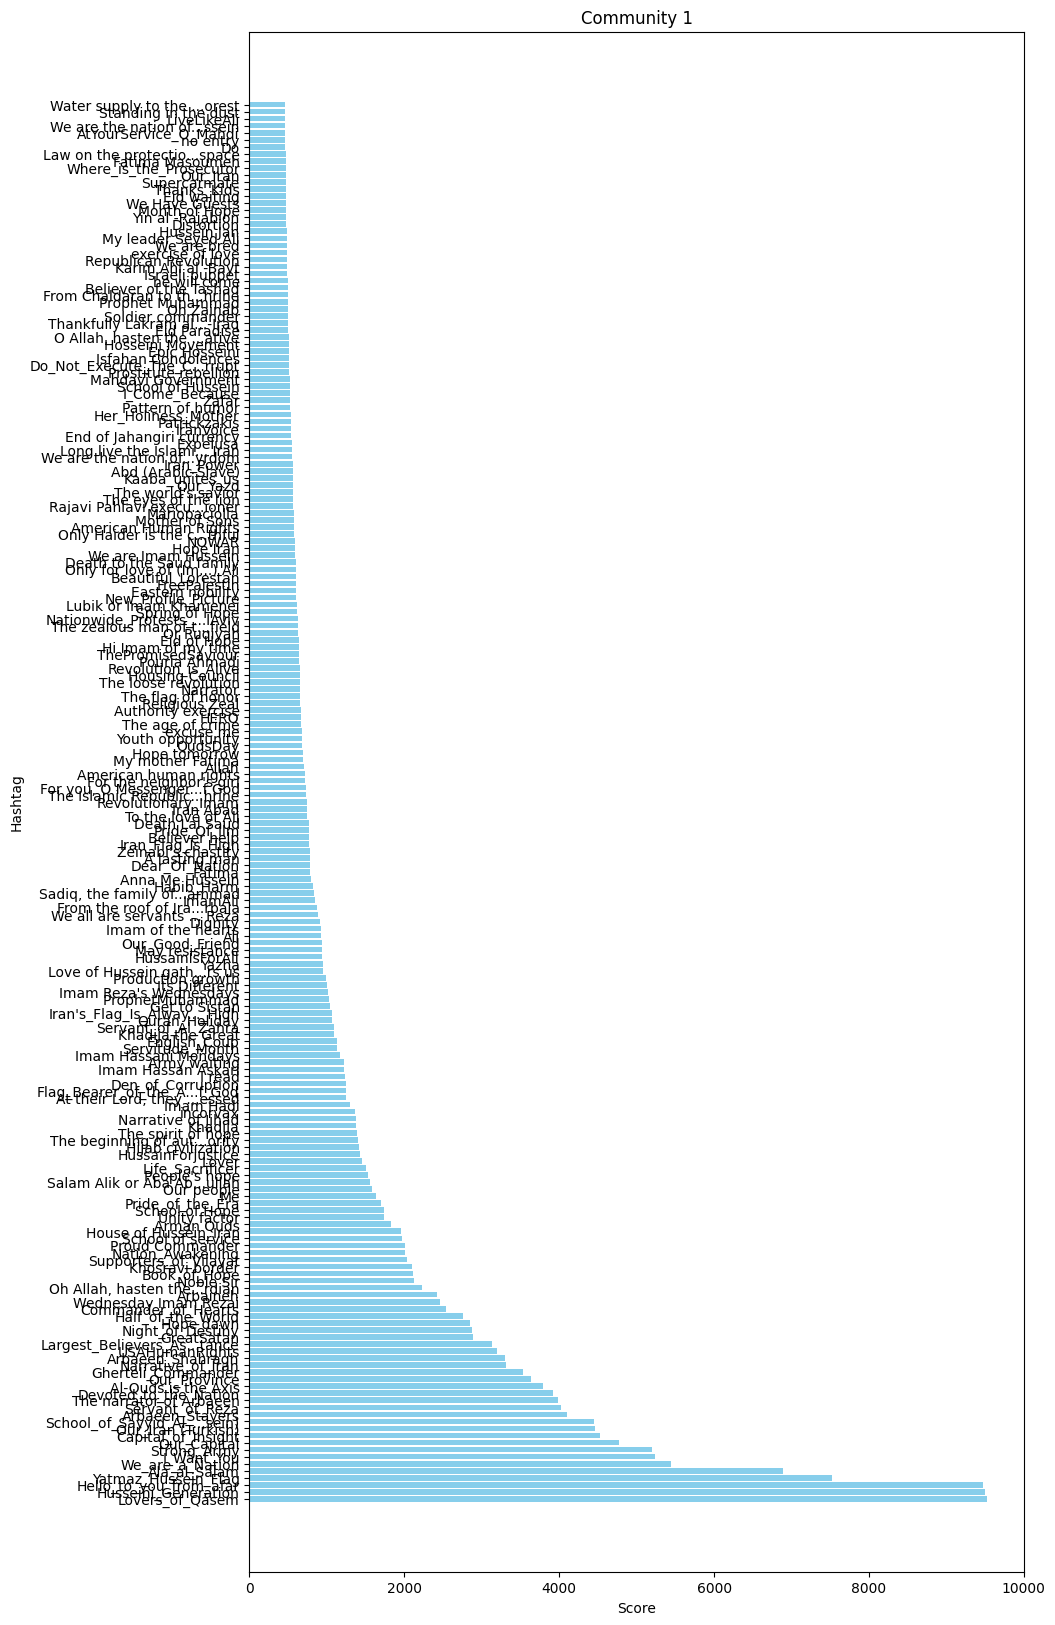

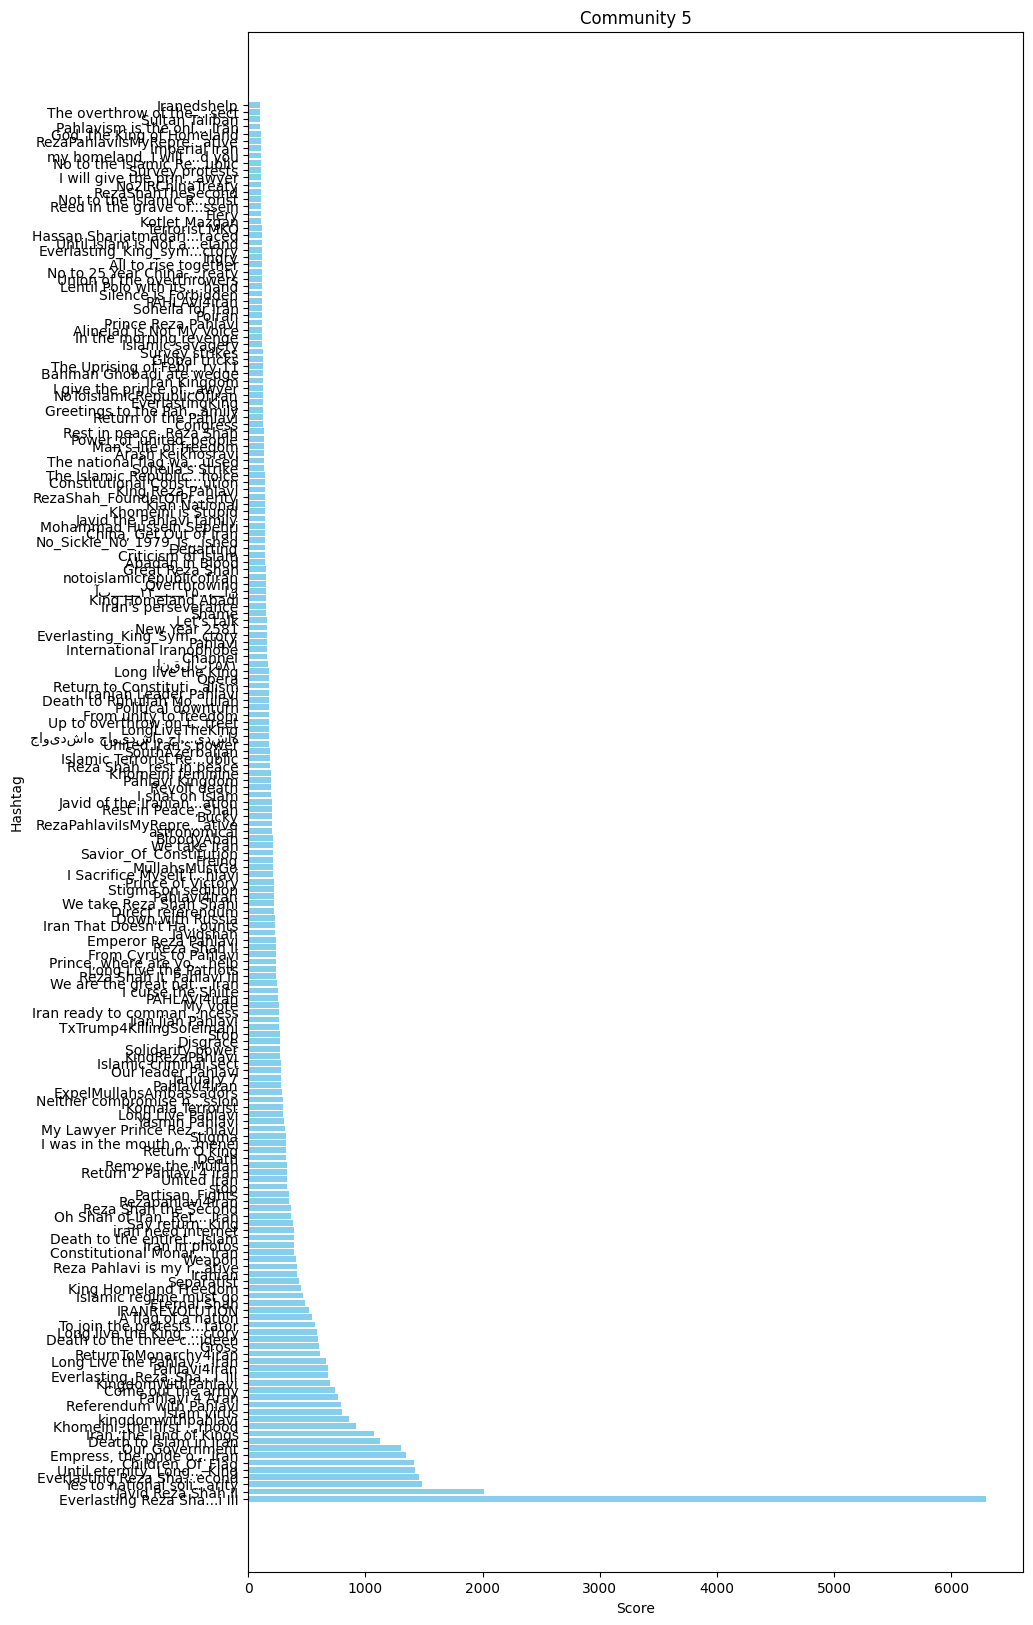

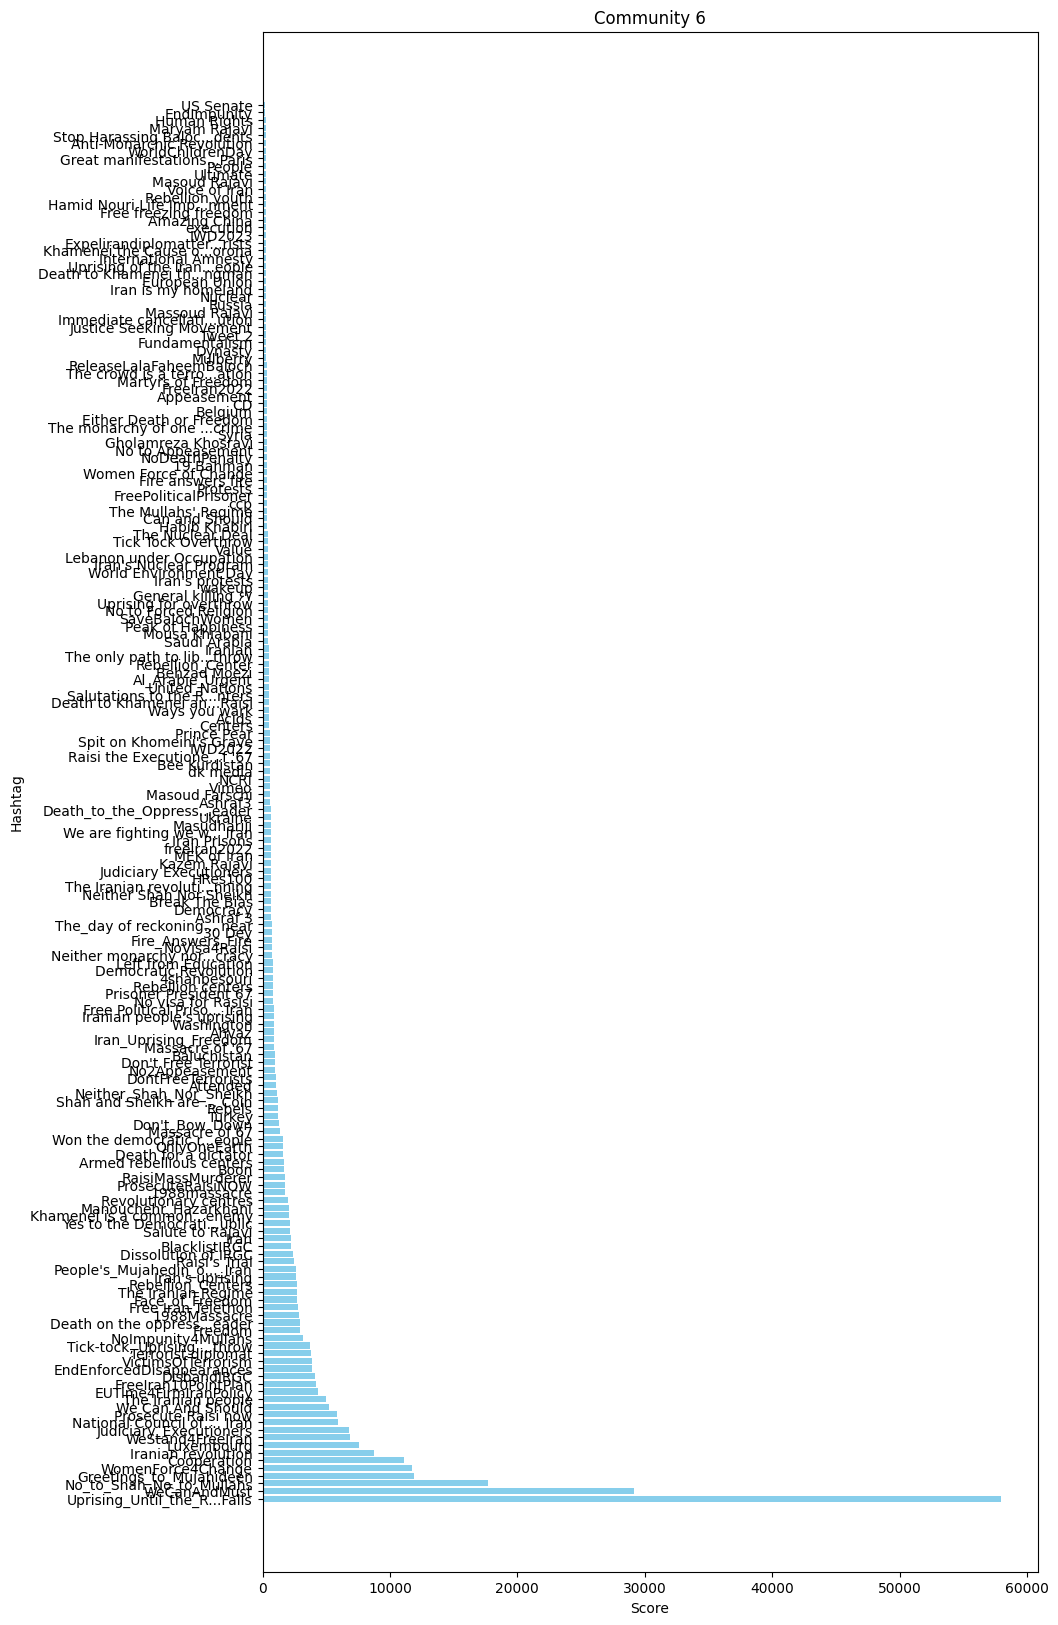

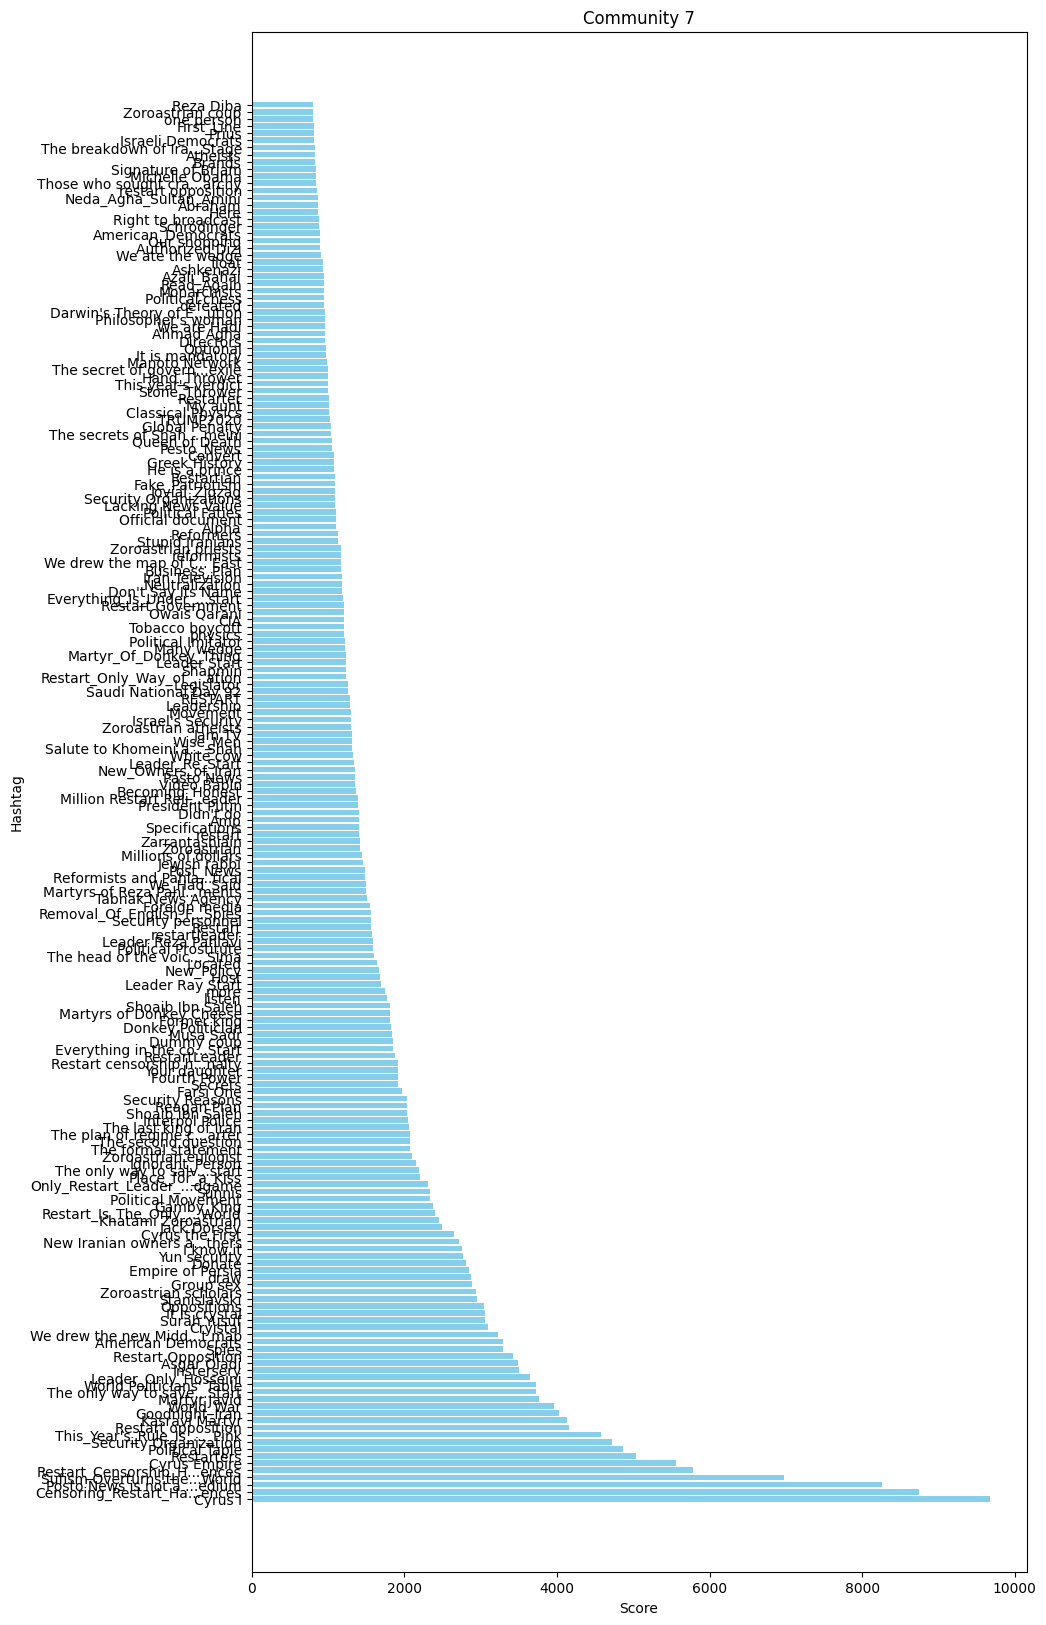

In [112]:
# Assuming translation_cache is a dictionary with hashtags as keys and translations as values
 

# Iterate over each community
for i, community in enumerate(communities):
    # Get the hashtags and scores for the current community
    hashtags, scores = zip(*exclusive_hashtags[community])
    
    # Translate the hashtags
    hashtags_translated = [get_translation(hashtag) for hashtag in hashtags]
    
    # trim hashtags to 20 characters for better display plus ... 
    hashtags_translated = [hashtag[:20] + '...' + hashtag[-5:] if len(hashtag) > 25 else hashtag for hashtag in hashtags_translated]

    

    # Create a new figure
    plt.figure(figsize=(10, 20))
    
    # Create a horizontal bar plot
    plt.barh(hashtags_translated, scores, color='skyblue')

    # Set a title
    plt.title(f'Community {community}')

    # Set x and y axis labels
    plt.xlabel('Score')
    plt.ylabel('Hashtag')

    # Display the plot
    plt.show()


In [111]:
translation_cache = {}  # Translation cache to store previously translated hashtags

# save the translation cache as json
import json

path = os.path.join(env["save"], "translation_cache.json")

translation_cache = json.load(open(path, "r"))


In [113]:
translation_cache

# save the translation cache as json
import json

path = os.path.join(env["save"], "translation_cache.json")
with open(path, "w") as f:
    json.dump(translation_cache, f, ensure_ascii=False, indent=4)

# 

In [80]:
print(type(translation_cache))  # Should print <class 'dict'>

<class 'dict'>


In [73]:

from googletrans import Translator
from httpx import Timeout
import time

translator = Translator(service_urls=['translate.google.com'], timeout=Timeout(5))

def translate(hashtag):
    """Translate a hashtag to English using the Google Translate API.

    Args:
        hashtag (str): The hashtag to translate.

    Returns:
        str: The translated hashtag.
    """
    # Translate the hashtag to English

    translated_hashtag = None
    while translated_hashtag is None:
        try:
            translation = translator.translate(hashtag.replace("_", " "), dest='en', src='auto')
            if hasattr(translation, 'text') and translation.text is not None:
                translated_hashtag = translation.text
                translation_cache[hashtag] = translated_hashtag
        except:
            time.sleep(5)  # Wait for 5 seconds before retrying
            continue
    # Return the translated hashtag
    return translation.text

def get_translation(hashtag):

    if hashtag in translation_cache:
        return translation_cache[hashtag]
    else:
        translated = translate(hashtag)
        translation_cache[hashtag] = translated
        return translated